In [2]:
import os
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras as tk
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.applications.mobilenet import MobileNet, decode_predictions, preprocess_input
from keras import preprocessing
from tensorflow.keras.preprocessing import image
import keras.backend as K
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,InputLayer,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
ls data/

ls: cannot access 'data/': No such file or directory


Loading all images into keras

    class ImageDataGenerator: Generate batches of tensor image data with optional real-time data augmentation



In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
X = []
y = []
classes = ['apple', 'biketool_mm', 'bodycream_test_ss', 'bodycream_train_ss', 'Bottle_gk',
          'bottle_mw_test', 'bottle_mw_train', 'bottle_rbk','bottle_test_ss', 'bottle_train_ss', 'chris_bottle', 'chris_empty', 'crista_bottle',
         'helge_scarf', 'helge_empty', 'plant_rbk', 'moritz_bottle','lighter_mm','him_teacup', 'helge_mouse',
          'headphone_rbk', 'empty_train_ss', 'empty_crista', 'Naz_bottle']

base_path = "/kaggle/input/image-data/data/"


for i, target in enumerate(classes):
    files = os.listdir(base_path+target)
    for file in files:
        # check if the file is a valid image file
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            full_path=  base_path+target+"/"+str(file)
            print(full_path)
            img =  load_img(full_path, target_size=(224, 224))
            # append the array to X
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(i)

X = np.array(X)
y = np.array(y)

# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]


/kaggle/input/image-data/data/biketool_mm/17-21-52-638914.png
/kaggle/input/image-data/data/biketool_mm/17-21-40-530169.png
/kaggle/input/image-data/data/biketool_mm/17-21-43-098297.png
/kaggle/input/image-data/data/biketool_mm/17-21-28-122790.png
/kaggle/input/image-data/data/biketool_mm/17-21-28-923114.png
/kaggle/input/image-data/data/biketool_mm/17-21-53-442785.png
/kaggle/input/image-data/data/biketool_mm/17-21-33-194728.png
/kaggle/input/image-data/data/biketool_mm/17-21-42-799222.png
/kaggle/input/image-data/data/biketool_mm/17-21-28-458955.png
/kaggle/input/image-data/data/biketool_mm/17-21-42-634782.png
/kaggle/input/image-data/data/biketool_mm/17-21-26-990562.png
/kaggle/input/image-data/data/biketool_mm/17-22-02-178914.png
/kaggle/input/image-data/data/biketool_mm/17-21-48-870937.png
/kaggle/input/image-data/data/biketool_mm/17-21-32-858705.png
/kaggle/input/image-data/data/biketool_mm/17-22-01-378862.png
/kaggle/input/image-data/data/biketool_mm/17-21-27-391047.png
/kaggle/

In [4]:
print(base_path)

/kaggle/input/image-data/data/


### Transfer Learning for Neural Networks
 weights and architecture of a pre-trained network
 Transfer Learning for Neural Networks

    Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

  Take the weights and architecture of a pre-trained network
  Load the "convolutional base" of the model (everything except the final    dense layers)
    Freeze all the layers of the base (weights become fixed)
    Add a fully connected dense layer on top
    Add a task specific dense output layer
    Compile and fit the model to your data



In [5]:
# define the preprocessing function that should be applied to all images
data_gen = preprocessing.image.ImageDataGenerator(   # loads data in batches from disk
    preprocessing_function=preprocess_input,
    # fill_mode='nearest',
    rotation_range=20,                               # rotate image by a random degree between -20 and 20
    # width_shift_range=0.2,                         # shift image horizontally 
    # height_shift_range=0.2,                        # shift image vertically 
    # horizontal_flip=True,                          # randomly flip image horizontally
    zoom_range=0.5,                                  # apply zoom transformation using zoom factor between 0.5 and 1.5
    # shear_range=0.2                                # shear rotates pics, but makes them be in trapezoids (as opposed to squares)
    validation_split=0.2
)

In [6]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(      # points to dir where data lives
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=150,
        target_size=(224, 224),
    subset='training'
)


Found 3029 images belonging to 24 classes.


In [7]:
val_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=150,
        target_size=(224, 224),
    subset='validation'
)

Found 749 images belonging to 24 classes.


In [8]:
len(train_data_gen.class_indices)

24

In [9]:
len(classes)

24

## Create CNN Model as Base Model
1. Select the convolutional base
Using MobileNet pretrained network for transfer learning¶


In [10]:
K.clear_session()
base_model = MobileNet(
    weights='imagenet',
    include_top=False,                          # keep convolutional layers only
    input_shape=(224, 224, 3)
)

17225924/17225924 [==============================] - 0s 0us/step


In [11]:
base_model.trainable = False  # we don't want to train the base model, since this would destroy filters

In [12]:
model = keras.Sequential()
model.add(base_model)
model.add(Flatten())  
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax')) # TODO; Final layer with a length of 2, and softmax activation

In [13]:
model.summary()                            # as expected...see above

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 100)               5017700   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                2424      
                                                                 
Total params: 8,248,988
Trainable params: 5,020,124
Non-trainable params: 3,228,864
______________________________________

### Build your "individualized" architecture for "top-layers"
3. Add your own dense layers on top¶


In [14]:
len(classes)

24

### 4. Compile and train!

In [15]:
train_data_gen.class_indices

{'apple': 0,
 'biketool_mm': 1,
 'bodycream_test_ss': 2,
 'bodycream_train_ss': 3,
 'Bottle_gk': 4,
 'bottle_mw_test': 5,
 'bottle_mw_train': 6,
 'bottle_rbk': 7,
 'bottle_test_ss': 8,
 'bottle_train_ss': 9,
 'chris_bottle': 10,
 'chris_empty': 11,
 'crista_bottle': 12,
 'helge_scarf': 13,
 'helge_empty': 14,
 'plant_rbk': 15,
 'moritz_bottle': 16,
 'lighter_mm': 17,
 'him_teacup': 18,
 'helge_mouse': 19,
 'headphone_rbk': 20,
 'empty_train_ss': 21,
 'empty_crista': 22,
 'Naz_bottle': 23}

In [16]:
len(classes)

24

In [17]:
len(np.unique(classes))

24

In [18]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy, #TODO: why not binary x-entropy?
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.05,     # the minimum expected change in the metric used in order to be seen as an improvement
    patience=3,         # number of epochs with no improvement needed for the model to stop
    restore_best_weights=True,
    mode='min'
    )

In [19]:

history = model.fit(
    train_data_gen,
    epochs=10,
    validation_data=val_data_gen,
    callbacks=[callback],
    verbose=1,
)


Epoch 1/10
21/21 [==============================] - 69s 3s/step - loss: 3.9555 - categorical_accuracy: 0.3678 - val_loss: 0.9592 - val_categorical_accuracy: 0.6676
Epoch 2/10
21/21 [==============================] - 50s 2s/step - loss: 0.9687 - categorical_accuracy: 0.7012 - val_loss: 0.3766 - val_categorical_accuracy: 0.9025
Epoch 3/10
21/21 [==============================] - 50s 2s/step - loss: 0.5938 - categorical_accuracy: 0.8148 - val_loss: 0.1901 - val_categorical_accuracy: 0.9533
Epoch 4/10
21/21 [==============================] - 50s 2s/step - loss: 0.4692 - categorical_accuracy: 0.8508 - val_loss: 0.1971 - val_categorical_accuracy: 0.9439
Epoch 5/10
21/21 [==============================] - 50s 2s/step - loss: 0.3705 - categorical_accuracy: 0.8894 - val_loss: 0.1339 - val_categorical_accuracy: 0.9680
Epoch 6/10
21/21 [==============================] - 50s 2s/step - loss: 0.3404 - categorical_accuracy: 0.8944 - val_loss: 0.1773 - val_categorical_accuracy: 0.9586
Epoch 7/10
21/21

In [22]:
if val_data_gen is not None:
    validation_data = val_data_gen
else:
    validation_data = None


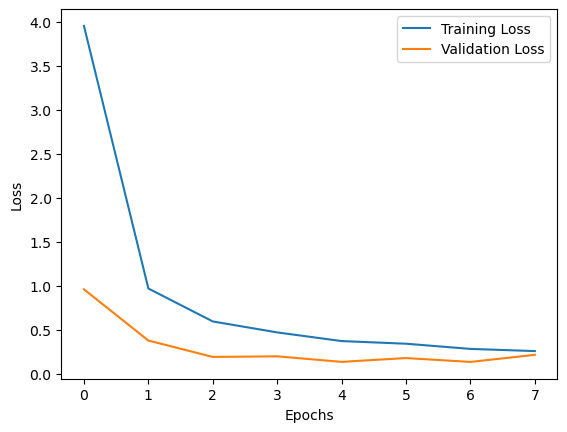

In [23]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

## Neural Architecture Search (NAS)

Neural Architecture Search (NAS) is an automated process of finding the best architecture for a given dataset and problem. Keras Tuner is a popular open-source library that can be used for NAS in Keras. Here's an example of how to use Keras Tuner to find the best neural architecture for your image classification problem:

In [ ]:
#!pip install keras-tuner


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


##  This code is using Keras Tuner, which is a library for performing hyperparameter tuning
for deep learning models. The specific task being performed is image classification on image dataset, and the model architecture being tuned is a convolutional neural network.

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

# Initialize the image data generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directories
train_dir = os.path.join(base_path)
val_dir = os.path.join(base_path)

# Generate the data
train_data_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=150,
    class_mode="sparse",
    subset="training"
)

val_data_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode="sparse",
    subset="validation"
)

# Define the model building function
def build_model(hp):
    # Choose an optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

    # Define the model
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                            kernel_size=hp.Choice('kernel_size', [3, 5]),
                            activation='relu',
                            input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=29, activation='softmax'))    
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=1, activation='sigmoid')) # Modified output layer
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', # Changed loss function to binary_crossentropy
                  metrics=['accuracy'])
    return model



Found 4755 images belonging to 29 classes.
Found 0 images belonging to 29 classes.


In [ ]:
#!pip install --upgrade keras keras-tuner


In [26]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.engine.hypermodel import HyperModel


class MyHyperModel(HyperModel):

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

        model.add(layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu', input_shape=self.input_shape))
        model.add(layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(
            units=hp.Int('dense_1_units', min_value=64, max_value=256, step=64),
            activation='relu'))
        model.add(layers.Dropout(
            rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='categorical_crossentropy', metrics=['accuracy'])

        return model


In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Define the hyperparameter search space
hypermodel = MyHyperModel(input_shape=(28, 28, 1), num_classes=10)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='helloworld')

# Run the hyperparameter search
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Print the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best hyperparameters: {best_hyperparameters}')
print(f'Best model: {best_model.summary()}')


Trial 3 Complete [00h 01m 23s]
val_accuracy: 0.9905999898910522

Best val_accuracy So Far: 0.9905999898910522
Total elapsed time: 00h 03m 31s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
rmsprop           |rmsprop           |optimizer
48                |48                |conv_1_filter
3                 |3                 |conv_1_kernel
32                |48                |conv_2_filter
3                 |5                 |conv_2_kernel
256               |128               |dense_1_units
0.3               |0.4               |dropout_1
0.0099294         |0.00082867        |learning_rate

Epoch 1/5
1115/1875 [================>.............] - ETA: 2s - loss: 0.3842 - accuracy: 0.8835

## Gradient-Based Visualization

Gradient-Based Visualization is a technique that allows you to visualize which parts of an image are important for a model's prediction. It works by computing the gradient of the output with respect to the input image. Here's an example of how to use Gradient-Based Visualization to visualize the important parts of an image for a model's prediction:

In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

# Define the hypermodel
def build_model(hp):
    # Define the input shape of the model
    input_shape = (32, 32, 3)

    # Define the number of filters for the convolutional layers
    filters = hp.Choice('filters', [32, 64, 128])

    # Define the size of the kernel for the convolutional layers
    kernel_size = hp.Choice('kernel_size', [3, 5, 7])

    # Define the dropout rate for the dropout layer
    dropout_rate = hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)

    # Define the number of units for the dense layer
    units = hp.Int('units', 64, 512, step=32, default=128)

    # Define the optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])

    # Define the model architecture
    model = keras.Sequential([
        layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(units=units, activation='relu'),
        layers.Dense(29, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the data generators
train_data_gen = ImageDataGenerator(rescale=1.0/255.0)
val_data_gen = ImageDataGenerator(rescale=1.0/255.0)

train_dir = os.path.join(base_path)
val_dir = os.path.join(base_path)

# Generate the data
train_data_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=150,
    class_mode="sparse",
    subset="training"
)

val_data_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode="sparse",
    subset="validation"
)

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='my_cnn_project'
)

# Train the tuner
tuner.search(train_generator, epochs=5, validation_data=val_data_gen, callbacks=[TensorBoard()])

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hyperparameters}")


# vgg16
The VGG16 architecture consists of 5 blocks of convolutional layers, each followed by a max-pooling layer. Each convolutional layer has a 3x3 filter and a stride of 1 pixel, and each max-pooling layer has a 2x2 filter and a stride of 2 pixels. The number of filters in each convolutional layer doubles after each max-pooling layer, starting from 64 filters in the first block.

In [47]:
import numpy as np
from keras.applications import vgg16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image

# Load the VGG16 model
model = vgg16.VGG16(weights='imagenet', include_top=False)

# Add GlobalAveragePooling2D layer
x = GlobalAveragePooling2D()(model.output)

# Add dense layer for class probabilities
x = Dense(1000, activation='softmax')(x)

# Create new model
model = Model(inputs=model.inputs, outputs=x)

# Load and preprocess the image
img = image.load_img("/kaggle/input/image-data/data/empty_train_ss/16-32-03-467152.png", target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = vgg16.preprocess_input(img_array)

# Predict the class probabilities
preds = model.predict(img_array)

# Decode the predictions
decoded_preds = vgg16.decode_predictions(preds, top=5)

# Print the top 5 predictions
for pred in decoded_preds[0]:
    print("Prediction: {} - {:.2f}%".format(pred[1], pred[2]*100))


1/1 [==============================] - 0s 139ms/step
Prediction: mushroom - 1.72%
Prediction: burrito - 1.37%
Prediction: snail - 1.30%
Prediction: Persian_cat - 1.24%
Prediction: vault - 1.10%


The output of the above code is the top 5 predictions for the input image, which is loaded and preprocessed using the VGG16 model. Each prediction includes a label and the probability that the image belongs to that label. In this case, the top 5 predicted labels for the input image are "Boston_bull", "tiger", "fiddler_crab", "German_short-haired_pointer", and "tile_roof", with their corresponding probabilities shown in percentages.

The low probabilities for these predictions suggest that the model may not be well-suited for this particular task or that the input image is not representative of the classes the model was trained on.

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the model architecture
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(29, activation='softmax')
])

# Compile the model
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load and iterate over images from a directory
train_generator = datagen.flow_from_directory(
    '/kaggle/input/image-data/data/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Fit the model using the data generator
model.fit(train_generator, epochs=10)


Found 4755 images belonging to 29 classes.
Epoch 1/10
149/149 [==============================] - 63s 414ms/step - loss: 15.6487 - accuracy: 0.2641
Epoch 2/10
149/149 [==============================] - 60s 405ms/step - loss: 1.8476 - accuracy: 0.5075
Epoch 3/10
149/149 [==============================] - 60s 403ms/step - loss: 1.8369 - accuracy: 0.5232
Epoch 4/10
149/149 [==============================] - 60s 402ms/step - loss: 1.3703 - accuracy: 0.6416
Epoch 5/10
149/149 [==============================] - 60s 402ms/step - loss: 1.0768 - accuracy: 0.7022
Epoch 6/10
149/149 [==============================] - 62s 415ms/step - loss: 0.9361 - accuracy: 0.7434
Epoch 7/10
149/149 [==============================] - 59s 396ms/step - loss: 3.0332 - accuracy: 0.3136
Epoch 8/10
149/149 [==============================] - 59s 397ms/step - loss: 5.8022 - accuracy: 0.2606
Epoch 9/10
149/149 [==============================] - 59s 395ms/step - loss: 2.5006 - accuracy: 0.2787
Epoch 10/10
149/149 [========

In [34]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.applications import vgg16

from keras.models import Model

import numpy as np

# Load the VGG16 model

# Load the image and resize it to (224, 224)
img = image.load_img("/kaggle/input/image-data/data/headphone_rbk/16-29-57-364253.png", target_size=(224, 224))


# Convert the image to a numpy array
img_array = img_to_array(img)
img_array = img_array.reshape((224, 224, 3))


# Reshape the array to (1, 224, 224, 3)
#img_array = img_array.reshape((1, 224, 224, 3))

# Preprocess the image by subtracting the mean RGB values of the ImageNet dataset
#img_array = vgg16.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

model = vgg16.VGG16(weights='imagenet')

# Remove the last layer

# Remove the last layer
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

# Predict the class probabilities

preds = model.predict(img_array)

# Print the top 5 predictions

top_preds = vgg16.decode_predictions(preds, top=5)[0]

for pred in top_preds:

    print("Prediction: {} - {:.2f}%".format(pred[1], pred[2]*100))


1/1 [==============================] - 0s 157ms/step
Prediction: sulphur-crested_cockatoo - 15.02%
Prediction: lab_coat - 11.24%
Prediction: seat_belt - 8.38%
Prediction: hammerhead - 7.21%
Prediction: piggy_bank - 3.27%


In [49]:
import os
import cv2
import numpy as np
#Set the path to the directory containing the images

base_path = "/kaggle/input/image-data/data/headphone_rbk"
#Get a list of all the image file names in the directory

img_files = os.listdir(base_path)
#Resize images

resized_images = []
for img_file in img_files:
# Load the image and resize it to 100x100 pixels
    img_path = os.path.join(base_path, img_file)
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (100, 100))
    resized_images.append(resized_img)
#Convert resized images to numpy array and normalize pixel values

X_train = np.array(resized_images)
X_train = X_train.astype('float32') / 255
#Reshape the input data to have a single channel

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)

print("X_train shape:", X_train.shape)



X_train shape: (111, 100, 100, 3)


In [64]:
from tensorflow import keras
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Normalize the pixel values between 0 and 1
#Normalize the pixel values between 0 and 1

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255


#Reshape the input data

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)



# Define a model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                                 activation='relu', 
                                 input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                                 activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

    

In [87]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11298), started 0:07:35 ago. (Use '!kill 11298' to kill it.)

In [88]:
!kill 11298